# MNIST Dataset Artifact

This notebook constructs a W&B artifact of the pre-processed, normalized MNIST dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import wandb

2023-02-14 16:56:50.278578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
config = dict(
    scaling_method = "normalize",
    # scaling_method = "standardize",
)

In [3]:
run = wandb.init(project="mnist_dataset", config=config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dwl2x. Use `wandb login --relogin` to force relogin


---
## Load the dataset

In [4]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()

In [5]:
original_shape = x_train.shape
original_shape

(60000, 28, 28)

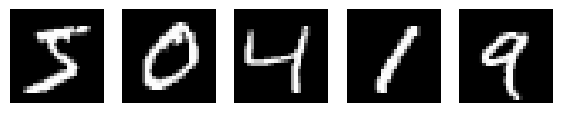

In [6]:
plt.figure(figsize=(7, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

---
## Data Exploration

In [7]:
labels, counts = np.unique(y_train, return_counts=True)

In [8]:
plt.title("Label Counts")
plt.bar(labels, counts)
plt.xticks(labels)
plt.xlabel("Count")
plt.ylabel("Digit")
wandb.log({ "data_distribution": plt })
plt.show()

---
## Pre-processing

Reshape into 3 dimensional images

In [9]:
# Apply data scaling
x_train = x_train.astype(float)
match config["scaling_method"]:
    case "normalize":
        x_train -= np.min(x_train)
        x_train = x_train / np.max(x_train)
    case "standardize":
        x_train -= np.mean(x_train)
        x_train = x_train / np.std(x_train)
    case _:
        raise Exception("Unknown scaling method")

In [10]:
# Reshape to appropriate shape
x_train = x_train.reshape(original_shape + (1,))
x_train.shape

(60000, 28, 28, 1)

---
## Log Artifact

In [11]:
save_path = os.path.join(run.dir, "mnist.npz")

In [12]:
np.savez_compressed(save_path, images=x_train, labels=y_train)

Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


In [13]:
artifact = wandb.Artifact(
    "mnist",
    type="dataset",
    metadata={
        "scaling_method": config["scaling_method"]
    }
)
artifact.add_file(save_path)
run.log_artifact(artifact)

In [14]:
run.finish()